In [1]:
# Import standard packages.
import numpy as np
from astropy.io import fits

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.

In [3]:
%matplotlib notebook

In [456]:
path = "../jwst-mtl/SOSS/extract/Ref_files/"

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata(path + "spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata(path + "spat_profile_m2.fits").squeeze())

In [5]:
from scipy.signal import convolve

In [19]:
from simulation_utils import GaussKer
from extract.convolution import gaussians

In [44]:
conv_in = gaussians(np.linspace(-100, 100, 501), 0, 1)
conv_in = conv_in / conv_in.sum()

conv_2 = gaussians(np.linspace(-100, 100, 501), 0, 3)
conv_2 = conv_2 / conv_2.sum()

<IPython.core.display.Javascript object>


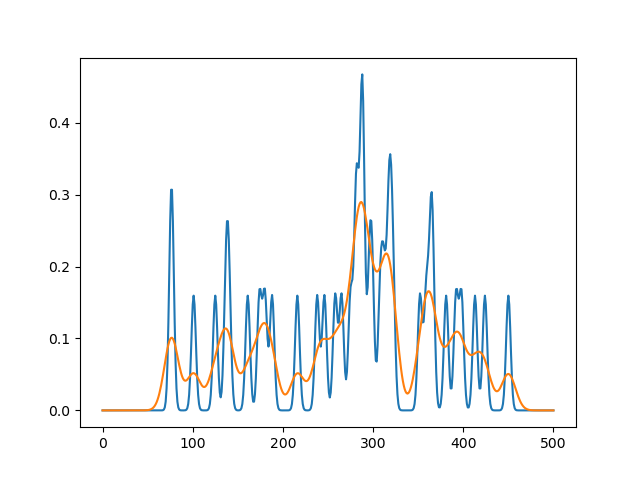

In [146]:
# f_in = 1 - (np.random.rand(501) > 0.9).astype(float)
f_in = (np.random.rand(501) > 0.9).astype(float)
f_in[:50] = 0
f_in[-50:] = 0
f_c2 = convolve(f_in, conv_in, mode='same')
f_c1 = convolve(f_c2, conv_2, mode='same')

plt.plot(f_c2)
plt.plot(f_c1)


In [102]:
def richardson_lucy(x, psf, guess=None, iterations=50, filter_epsilon=None):

    if guess is None:
        guess = np.full(x.shape, 0.5, dtype=float)
    
    im_deconv = guess.copy()
        
    psf_mirror = np.flip(psf)

    for _ in range(iterations):
        conv = convolve(im_deconv, psf, mode='same')
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, x / conv)
        else:
            relative_blur = x / conv
        im_deconv *= convolve(relative_blur, psf_mirror, mode='same')
#         plt.plot(im_deconv)

    return im_deconv

# def richardson_lucy(x, psf, guess=None, iterations=50, filter_epsilon=None):

#     if guess is None:
#         guess = 0.5
    
#     im_deconv = guess

#     for _ in range(iterations):
#         conv = im_deconv * psf
# #         convolve(im_deconv, psf, mode='same')
#         if filter_epsilon:
#             relative_blur = np.where(conv < filter_epsilon, 0, x / conv)
#         else:
#             relative_blur = x / conv
#         plt.plot(relative_blur)
#         im_deconv *= relative_blur #convolve(relative_blur, psf_mirror, mode='same')

#     return im_deconv

In [147]:
def trim_box(f_in, f_conv, box_h_len, guess):

    f_in_box = f_in.copy()
    f_in_box[:box_h_len] = 0
    f_in_box[-box_h_len:] = 0

    f_conv_box = convolve(f_in_box, guess, mode='same')
    f_conv_box[box_h_len:-box_h_len] = f_conv[box_h_len:-box_h_len]
    
    return f_in_box, f_conv_box
#  Trim box example
# init_guess = gaussians(np.linspace(-100, 100, 501), 0, 5)
# f_c2_box, f_c1_box = trim_box(f_c2, f_c1, 10, init_guess)
# ker = richardson_lucy(f_c1_box/f_c1_box.sum(), f_c2, guess=init_guess, iterations=10)

# plt.plot(ker)

# for i in range(5):

#     f_c2_box, f_c1_box = trim_box(f_c2, f_c1, 10, ker)
#     ker = richardson_lucy(f_c1_box/f_c1_box.sum(), f_c2, guess=init_guess, iterations=10)
#     plt.plot(ker)
# plt.plot(init_guess, "r--", alpha=0.4)
# plt.plot(conv_2, "k--", alpha=0.4)

<IPython.core.display.Javascript object>


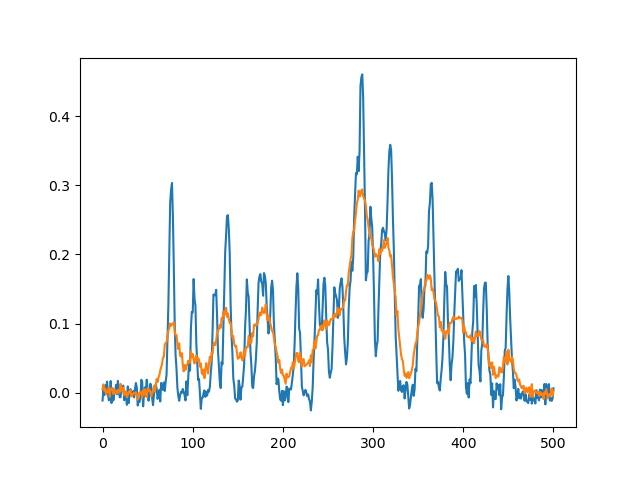

In [155]:
f_c1_noisy = np.random.normal(0, 0.005, size=f_c1.shape)
f_c2_noisy = np.random.normal(0, 0.01, size=f_c1.shape)
f_c2_noisy = f_c2 + f_c2_noisy
f_c1_noisy = f_c1 + f_c1_noisy
plt.plot(f_c2_noisy)
plt.plot(f_c1_noisy)

<IPython.core.display.Javascript object>


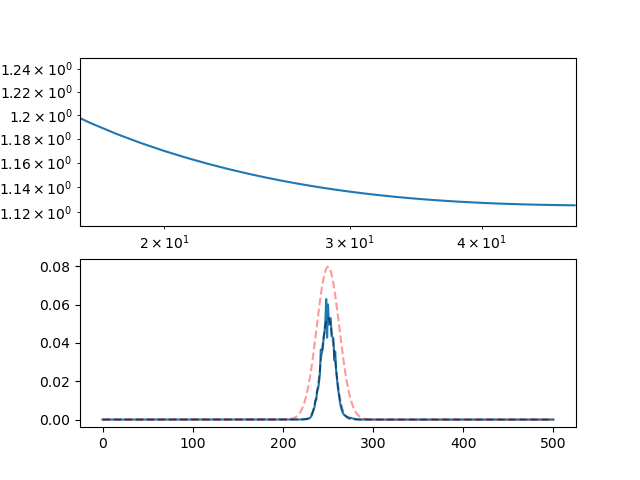

In [176]:
init_guess = gaussians(np.linspace(-100, 100, 501), 0, 5)

img = f_c1_noisy/f_c1_noisy.sum()
f_input = np.clip(f_c2_noisy, 0, None)

ker = richardson_lucy(img, f_input, guess=init_guess, iterations=1)

fig, ax = plt.subplots(2, 1)
chi2 = []
n_iter = np.arange(1, 50, 1)
for i in n_iter:
    ker = richardson_lucy(img, f_input, guess=ker, iterations=1)
    err = f_c1_noisy - convolve(f_c2_noisy, ker, mode='same')
    chi2.append(np.mean((err/0.005)**2))
ax[1].plot(ker)
ax[0].loglog(n_iter, chi2)
ax[1].plot(init_guess, "r--", alpha=0.4)
ax[1].plot(conv_2, "k--", alpha=0.4)

<IPython.core.display.Javascript object>


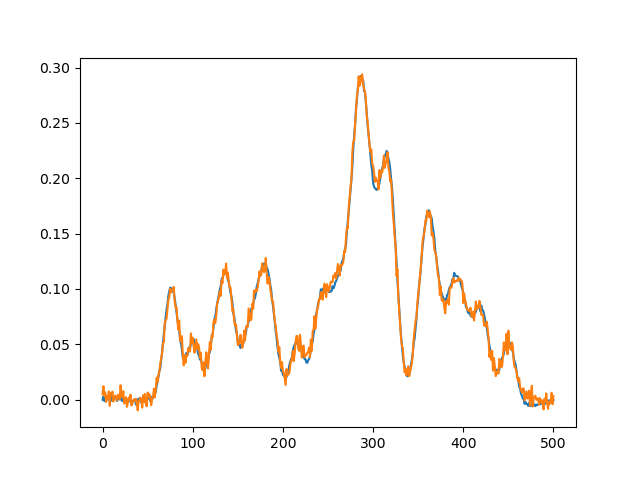

In [159]:
plt.plot(convolve(f_c2_noisy, ker, mode='same'))
plt.plot(f_c1_noisy)

In [111]:
psf = spat_pros[0][:, 1000]
f_in = np.zeros(psf.shape, dtype=float)
# -1 si pair
f_in[len(f_in) // 2 - 1] = 100.
print(len(f_in) // 2, len(f_in))
x = convolve(psf, f_in, mode='same')

128 256


<IPython.core.display.Javascript object>


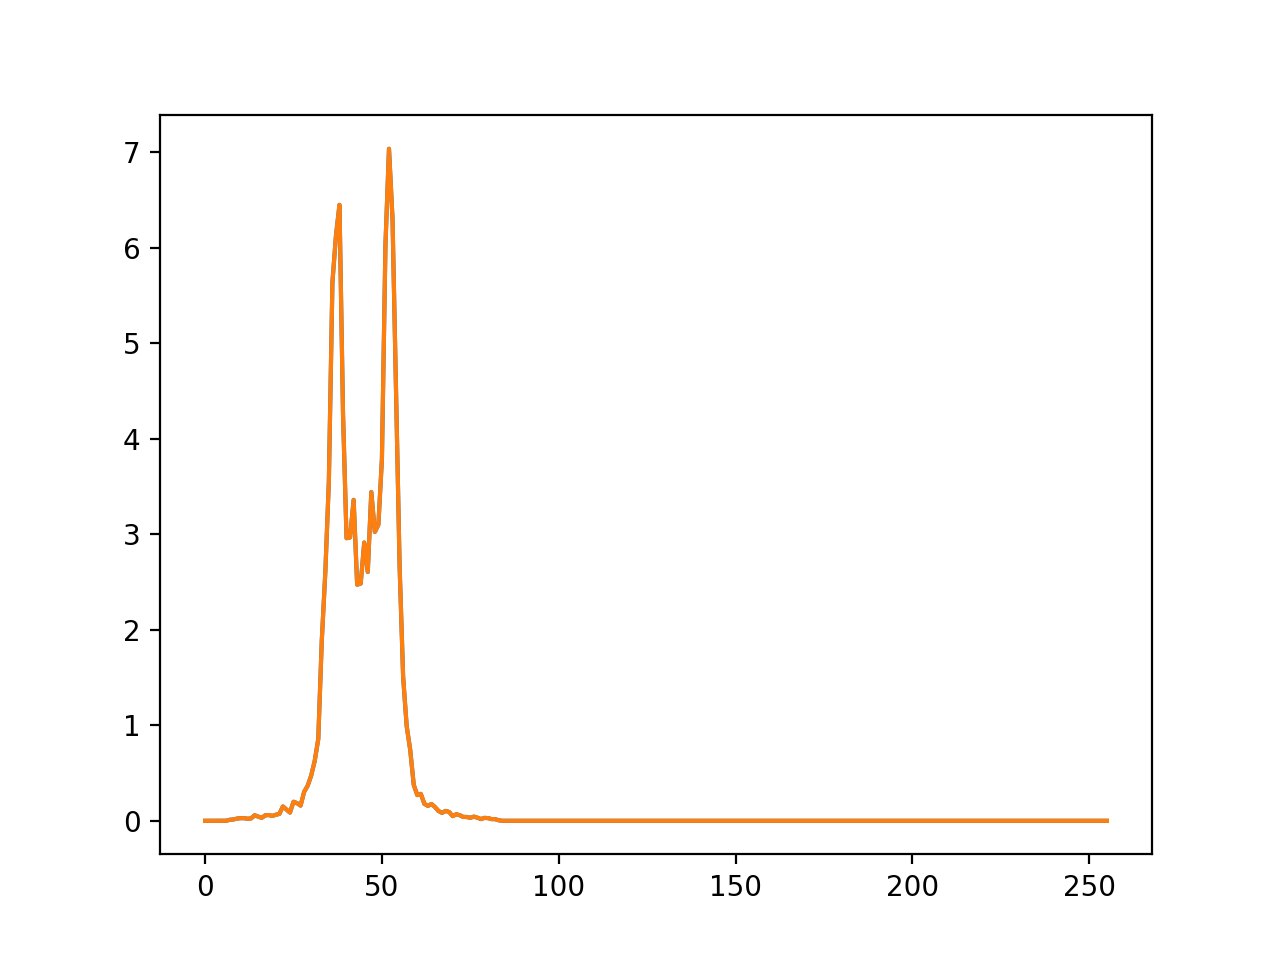

In [95]:
plt.plot(psf * 100)
plt.plot(x)


<IPython.core.display.Javascript object>


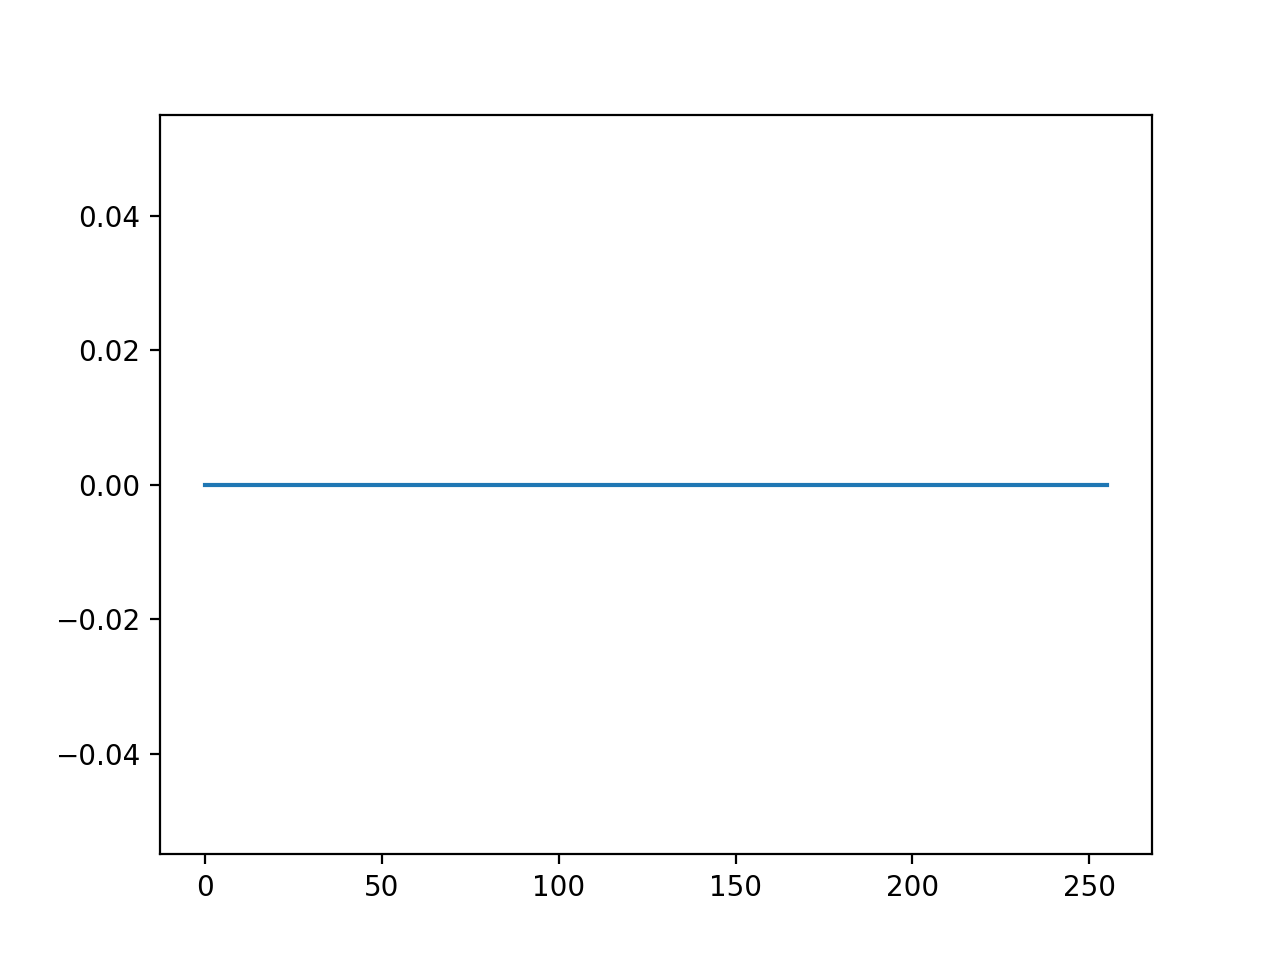

In [96]:
# plt.plot(psf * 100)
plt.plot(x - psf * 100)


/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


<IPython.core.display.Javascript object>


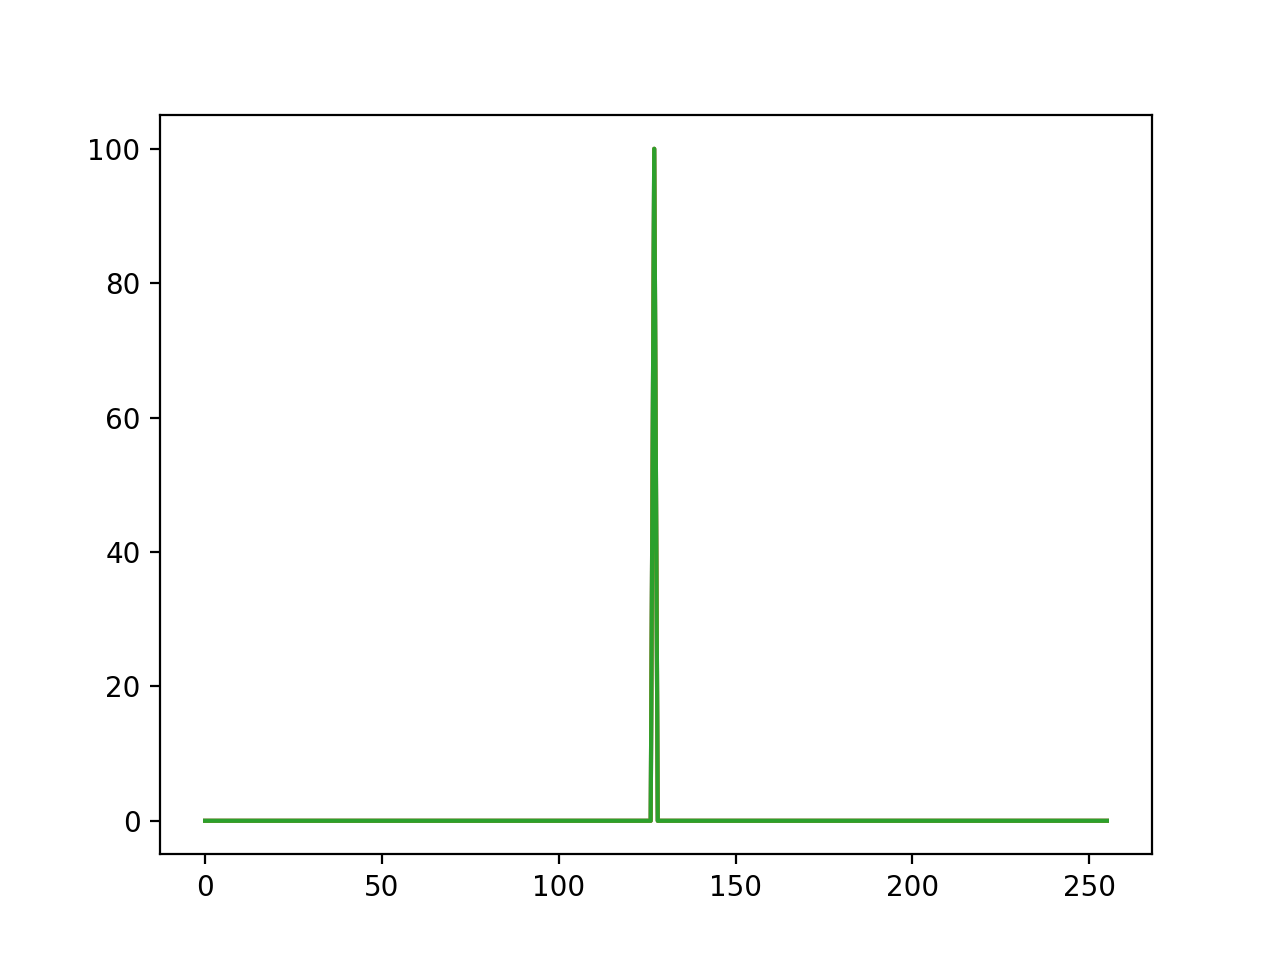

/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [123]:
recovered = richardson_lucy(x, psf, guess=0.5 * f_in, iterations=2, filter_epsilon=1e-6)
plt.plot(f_in)

<IPython.core.display.Javascript object>


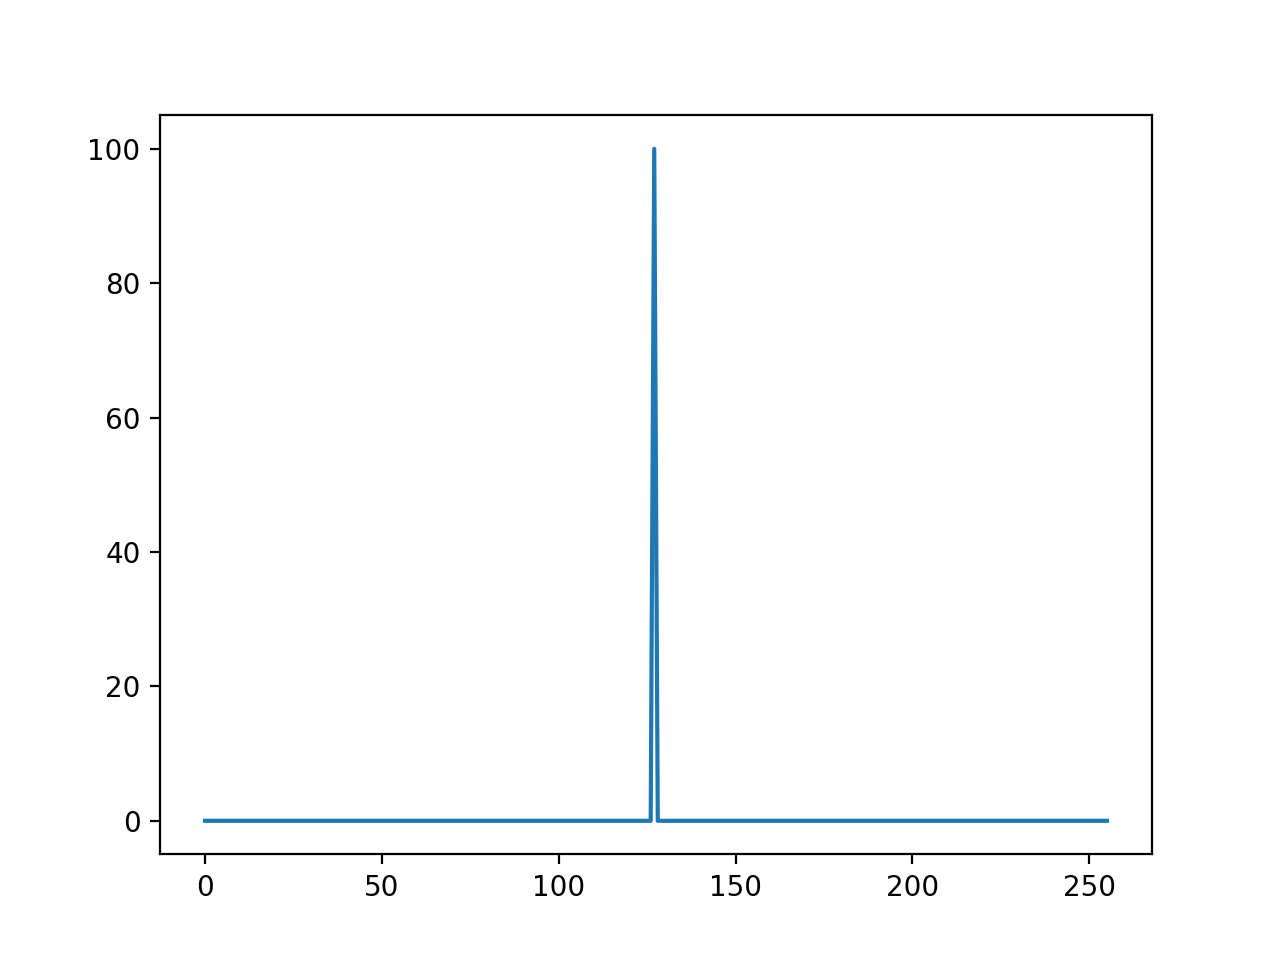

In [104]:
plt.plot(recovered)

<IPython.core.display.Javascript object>


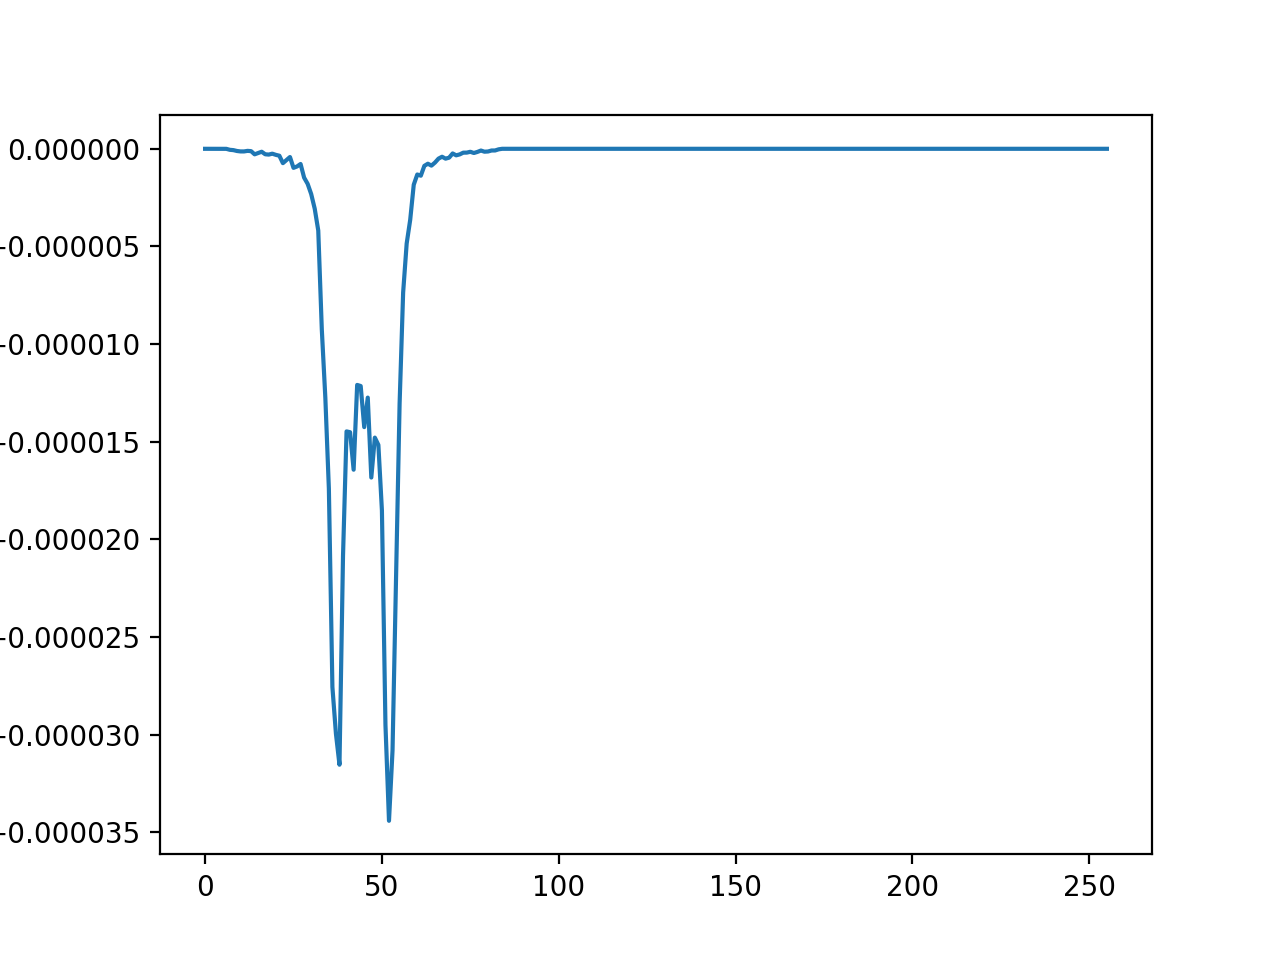

In [108]:
# plt.plot(x)
plt.plot(convolve(recovered, psf, mode='same')-x)

/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


<IPython.core.display.Javascript object>


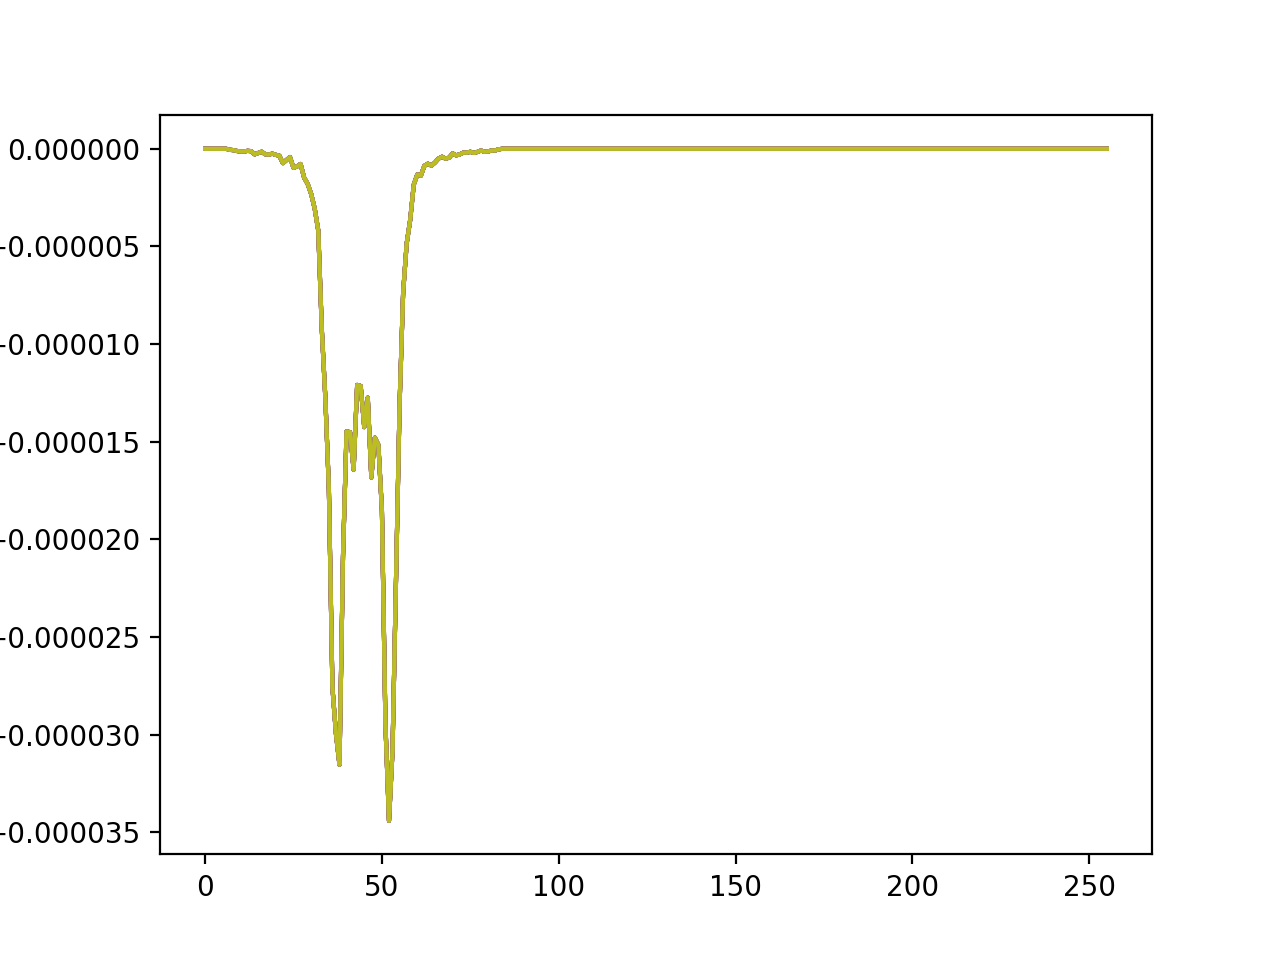

/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel

In [60]:
# plt.plot(x)

for n_iter in np.arange(100, 1000, 100):
    recovered = richardson_lucy(x, psf, guess=f_in, iterations=n_iter, filter_epsilon=1e-8)
    plt.plot(convolve(recovered, psf, mode='same')-x, label=n_iter)

# Richardson-lucy on spatial profile

In [249]:
from scipy.sparse import diags, hstack, csr_matrix
from scipy.sparse.linalg import spsolve

In [457]:
spat_pros_save = spat_pros

In [1103]:
spat_pros = [sp_pro[:, 499:500] for sp_pro in spat_pros_save]
# spat_pros = [spat_pros_save[0]]
spat_pros_estim = [(sp_pro > 1e-8).astype(float) for sp_pro in spat_pros]

shape = spat_pros[0].shape

# f_simu = [np.arange(shape[1]) + 1000, np.arange(shape[1]) + 100]
f_simu = [np.ones(shape[1]) + 1000000, np.ones(shape[1]) + 10000]

data = []
mask_ord = []
truth = []
estim = []
F_pix = []
# image = []
for i in range(len(spat_pros)):
    f_simu_ord = np.tile(f_simu[i], (shape[0], 1))
    data.append(f_simu_ord * spat_pros[i])
#     error.append(np.ones(data[i].shape))
    mask_ord.append(spat_pros[i] < 1e-8)

mask = np.all(mask_ord, axis=0)
# mask = np.any(mask_ord, axis=0)
data = np.sum(data, axis=0)

data = np.random.poisson(data).astype(float)
data += np.random.normal(scale=20, size=data.shape)
error = np.sqrt(np.abs(data) + 20**2)
for i in range(len(spat_pros)):
    f_simu_ord = np.tile(f_simu[i], (shape[0], 1))
    f_simu_ord[spat_pros_estim[i] <= 1e-8] = 0
    # build linear system
    F_pix.append(diags((f_simu_ord)[~mask]))
    truth.append(spat_pros[i][~mask])
    estim.append(spat_pros_estim[i][~mask])
#     image.append(data[~mask])
    
F_pix = hstack(F_pix)
truth = np.concatenate(truth)
estim_init = np.concatenate(estim)
image = data[~mask]
sig = error[~mask]

In [1104]:
estim = estim_init# / np.sum(estim_init)

<IPython.core.display.Javascript object>


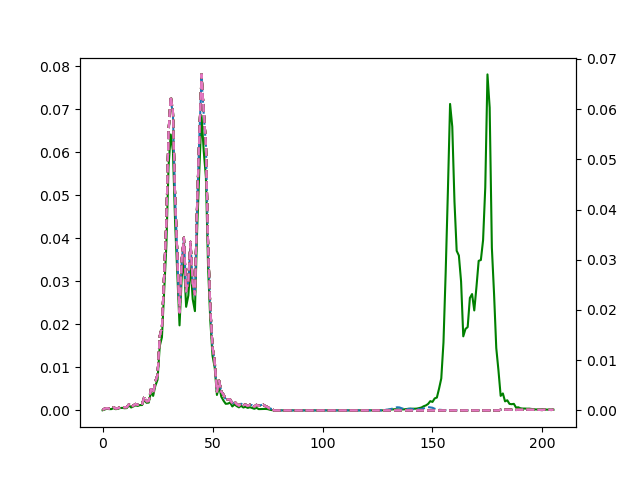

In [1084]:
plt.figure()


plt.plot(truth, "g")
plt.gca().twinx().plot(estim, "--")

In [1105]:
image = (100+image)
image = image/image.sum()
# F_pi

<IPython.core.display.Javascript object>


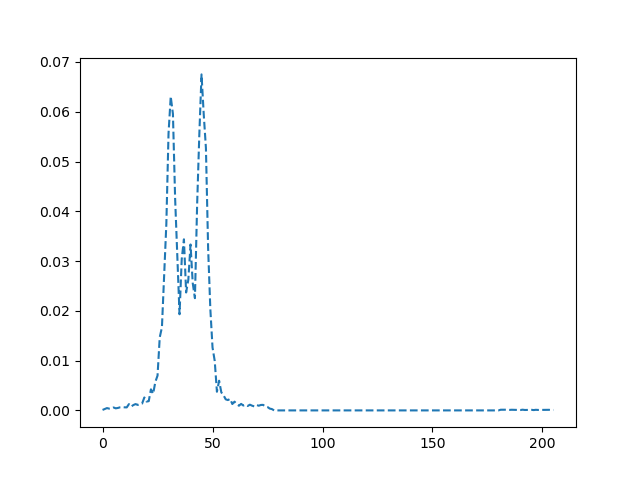

In [1109]:
phy_r = F_pix.dot(estim)
estim = estim * csr_matrix(image / phy_r).dot(F_pix).toarray().squeeze()
# estim = estim * (1 + np.repeat(erf((image - phy_r)/sig/np.sqrt(2)), 2))
# estim = estim * F_pix.T.dot(image / phy_r)

# plt.plot(truth, "g")
plt.plot(estim, "--")
# plt.plot(estim, "--")

In [1110]:
new_spat_pro = np.ones_like(spat_pros) * np.nan
new_spat_pro[0][~mask] = estim[:len(estim)//2]
new_spat_pro[1][~mask] = estim[len(estim)//2:]

rebuild = np.ones_like(data) * np.nan
rebuild[~mask] = F_pix.dot(estim)

<IPython.core.display.Javascript object>


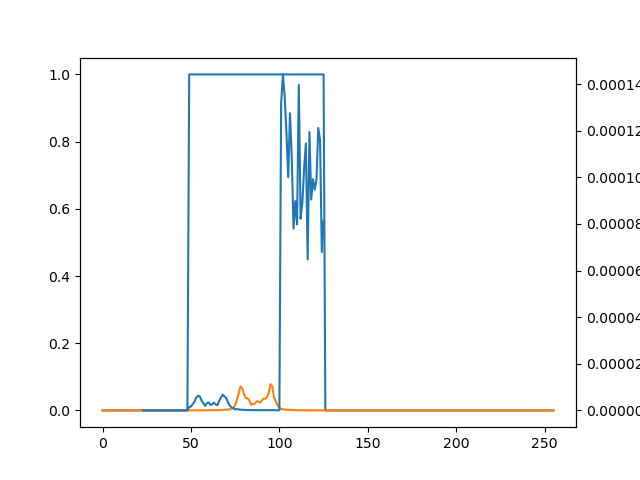

In [1111]:

plt.plot(spat_pros_estim[1][:,0])
plt.plot(spat_pros[1][:,0])

plt.gca().twinx().plot(new_spat_pro[1][:,0])

# plt.plot(rebuild[:,0])
# plt.plot(data[:,0])

# Test error function

In [506]:
from scipy.special import erf

In [541]:
np.ma.masked_less()

In [989]:
spat_pros = [sp_pro[:, 499:500] for sp_pro in spat_pros_save]
# spat_pros = [spat_pros_save[0]]
# spat_pros_estim = [(sp_pro > 1e-8).astype(float) for sp_pro in spat_pros]
spat_pros_estim = [sp_pro for sp_pro in spat_pros]

shape = spat_pros[0].shape

# f_simu = [np.arange(shape[1]) + 1000, np.arange(shape[1]) + 100]
f_simu = [np.ones(shape[1]) + 1000000, np.ones(shape[1]) + 10000]

data = []
mask_ord = []
truth = []
estim = []
F_pix = []
# image = []
for i in range(len(spat_pros)):
    f_simu_ord = np.tile(f_simu[i], (shape[0], 1))
    data.append(f_simu_ord * spat_pros[i])
#     error.append(np.ones(data[i].shape))
#     mask_ord.append(spat_pros[i] < 1e-2)

# mask = np.all(mask_ord, axis=0)
# mask = np.any(mask_ord, axis=0)
data = np.sum(data, axis=0)

data = np.random.poisson(data).astype(float)
data += np.random.normal(scale=20, size=data.shape)
error = np.sqrt(np.abs(data)) + 20



# for i in range(len(spat_pros)):
#     f_simu_ord = np.tile(f_simu[i], (shape[0], 1))
#     # build linear system
#     F_pix.append(f_simu_ord/error)
#     truth.append(spat_pros[i][~mask])
#     estim.append(spat_pros_estim[i][~mask])
# #     image.append(data[~mask])
    
# F_pix = hstack(F_pix)
# truth = np.concatenate(truth)
# estim_init = np.concatenate(estim)
# image = data[~mask]
# sig = error[~mask]

In [990]:
estim = np.array(spat_pros_estim)
chi2 = []

<IPython.core.display.Javascript object>


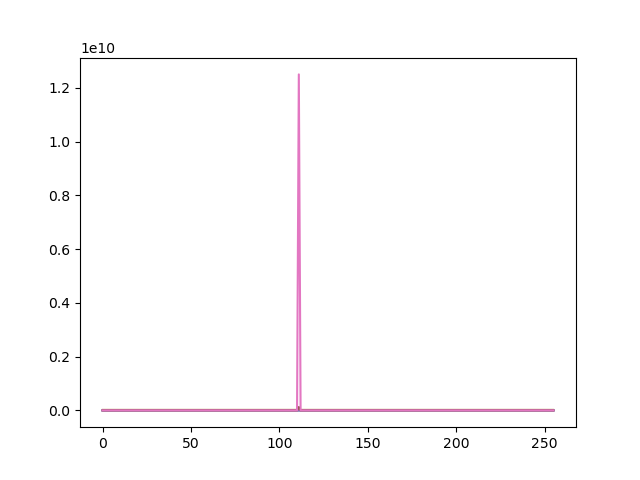

In [991]:
# fig 

# plt.plot(spat_pros[1])
# plt.plot(estim[1])

plt.plot(data)
# plt.plot((estim * np.array(f_simu)[:, None, :])[0])
plt.plot((estim * np.array(f_simu)[:, None, :])[1])

In [1000]:

for i in range(1):
    estim = np.clip(estim, 1e-8, None)
    estim /= np.sum(estim, axis=1)[:,None, :]

    phy_r = estim * np.array(f_simu)[:, None, :]
    
    chi2.append(np.nanmean(((data - np.sum(phy_r,axis=0))/error)**2))

    estim = estim * (1 + np.abs(erf((data - np.sum(phy_r,axis=0))/error/np.sqrt(2)))*(data - np.sum(phy_r,axis=0))/data )
#     estim = estim * (1 + (data - np.sum(phy_r, axis=0))/data )

In [1001]:
# plt.plot(estim[1])
# plt.plot((estim * np.array(f_simu)[:, None, :])[0])

plt.plot((estim * np.array(f_simu)[:, None, :])[1])

In [1002]:
chi2

[0.6139012949920809,
 0.47848179098132604,
 0.7646070261468652,
 569.465998197299,
 3433159.19743249]

# Test trust-constr (scipy)

In [1501]:
spat_pros = [sp_pro[:, 499:500] for sp_pro in spat_pros_save]
# spat_pros = [spat_pros_save[0]]
spat_pros_estim = [(sp_pro > 1e-8).astype(float) for sp_pro in spat_pros]
spat_pros_estim = [sp_pro/sp_pro.sum(axis=0) for sp_pro in spat_pros_estim]

shape = spat_pros[0].shape

# f_simu = [np.arange(shape[1]) + 1000, np.arange(shape[1]) + 100]
f_simu = [np.ones(shape[1]) + 1000000, np.ones(shape[1]) + 100000]
bkgd = 1000

data = []
mask_ord = []
truth = []
estim = []
F_pix = []
sig_psf = []
for i in range(len(spat_pros)):
    f_simu_ord = np.tile(f_simu[i], (shape[0], 1))
    data.append(f_simu_ord * spat_pros[i])
    mask_ord.append(spat_pros[i] < 1e-8)

mask = np.all(mask_ord, axis=0)
# mask = np.any(mask_ord, axis=0)
data = np.sum(data, axis=0) + bkgd

data = np.random.poisson(data).astype(float)
data += np.random.normal(scale=20, size=data.shape)
error = np.sqrt(data+20**2)

In [1475]:
from scipy.optimize import minimize, Bounds, LinearConstraint

In [1476]:
from scipy.sparse import identity

In [1686]:
def fit_profile_trust_constr(scidata, profile_estim, profile_range, flux_pix, error_map,
                             thresh_error=1, thresh_profile=1e-8, mask=None, options=None):
    ''' 
    Determine the best spatial profile estimate
    at a given column. Assume 2 overlapping orders. Each value
    of the spatial profiles at each order is considered an independent variable.
    The function to minimize is the chi^2, subject to the constraint that
    the spatial profiles are normalized to 1 (sum(spat_pro_ord) = 1).
    Also, the values of a profile at a given pixel must lie between
    some boundaries around the estimate of the spatial profile.    
    '''
    # Number of orders (always 2)
    n_ord = 2

    # Define which pixels will be used for the fit
    # according to the profile
    mask_ord = (thresh_profile > profile_estim)
    
    # Estimate of the image order by order
    data_ord = profile_estim * flux_pix
    # Define which pixels will be used for the fit
    # according to the relative error
    mask_ord &= (thresh_error > (data_ord / error_map))

    # Use mask_ord to define global mask if not given
    if mask is None:
        mask = np.all(mask_ord, axis=0)

    # ############
    # Build linear systems
    # ############
    
    # Which pixel are used for the fit at each orders
    good_pix = [~(ma_ord[~mask]) for ma_ord in mask_ord]
    
    # Number of pixels used for the fit
    n_good_pix = [g_pix.sum() for g_pix in good_pix]
    
    # Flux matrix
    flux_matrix = []
    for i_ord in range(n_ord):
        # Flux matrix for each orders
        gargs = (mask, good_pix[i_ord], flux_pix[i_ord])
        f_matrix = get_flux_matrix(*gargs)
        flux_matrix.append(f_matrix)
    # Combine to get a single matrix (N_pix X 2*N_pix)
    flux_matrix = hstack(flux_matrix)
    
    # Detector image vector (scidata)
    image_vec = scidata[~mask]
    
    # Detector error vector (error_map)
    err_vec = error_map[~mask]
    
    # Profile estimate vector
    prof_vec = []
    # Use valid pixels for each orders
    for i_ord, idx in enumerate(good_pix):
        prof_vec.append(profile_estim[i_ord][~mask][idx])
    # Combine in a single vector
    prof_vec = np.concatenate(prof_vec)

    # ########################################    
    # Define needed functions for optimization
    # ########################################

    # Pre-compute some matrix multiplications for efficiency
    
    # Matrix of the flux divided by the error map 
    flux_err = diags(1/err_vec).dot(flux_matrix)
    
    # Square of this matrix
    flux_err_square = flux_err.T.dot(flux_err)

    # Constant term used in the jacobian function
    const_jac = flux_err.T.dot(image_vec / err_vec)
    
    # chi^2 is the function to minimize
    def chi2_fct(profile):
        '''Compute the chi2 given a profile estimae'''
        
        # Image estimate
        rebuild = flux_matrix.dot(profile)
        # chi2 terms
        term = (image_vec - rebuild) / err_vec
        # chi2 sum
        out = 0.5 * np.sum(term**2)

        return out

    def chi2_jac(profile):
        '''Compute the jacobian of the chi2 function'''
        
        # Use pre-computed matrix
        out = flux_err_square.dot(profile) - const_jac

        return out

    def chi2_hess(profile):
        '''Compute hessian matrix of the chi2 function.
        Does not depend on the profile, but the minimzation procedure
        requires it.
        '''
        return flux_err_square
    
    # ##################
    # Define constraints
    # ##################
    
    # ##### Normalization constraint ##########
    # Equivalent to sum(profile) = 1 for each orders
    norm_matrix = get_norm_matrix(n_good_pix)
    
    # Translate to a scipy.optimize constraint
    norm_constr = LinearConstraint(norm_matrix, [1,1], [1,1])
    
    # ##### Boundaries constraint #######
    
    # Unpack profile range
    low_bnds, up_bnds = profile_range

    # Convert boundaries to vector
    low_bnds_vec, up_bnds_vec = [], []
    
    # Use valid pixels for each orders
    for i_ord, idx in enumerate(good_pix):
        low_bnds_vec.append(low_bnds[i_ord][~mask][idx])
        up_bnds_vec.append(up_bnds[i_ord][~mask][idx])

    # Combine in a single vector
    low_bnds_vec = np.concatenate(low_bnds_vec)
    up_bnds_vec = np.concatenate(up_bnds_vec)

    # Translate to a scipy.optimize constraint
    gargs = (identity(len(prof_vec)), low_bnds_vec, up_bnds_vec)
    bounds_constr = LinearConstraint(*gargs)
    
    # #########
    # Minimize!
    # #########
    default_kwargs = {'method': 'trust-constr',
                      'jac': chi2_jac,
                      'hess': chi2_hess,
                      'constraints': [bounds_constr, norm_constr]}
    result = minimize(chi2_fct, prof_vec, **default_kwargs, options=options)
    
    # Convert best fit to the input profile estimate format
    best_profile = np.ones(np.shape(profile_estim)) * np.nan

    # Split the best solution into orders
    sln_ord = (result.x[:n_good_pix[0]], )
    sln_ord += (result.x[n_good_pix[0]:], )
    
    # Assign values to valid pixels
    for i_ord in range(n_ord):
        idx = np.where(~mask)[0][good_pix[i_ord]]
        best_profile[i_ord][idx] = sln_ord[i_ord]
    
    return best_profile, mask, good_pix, result

def get_norm_matrix(n_good_pix):
    
    # Number of valid pixels for each orders
    n_ord_1, n_ord_2 = n_good_pix
    
    # Build 2 rows (for each orders)
    norm_mat_1 = [np.ones(n_ord_1), np.zeros(n_ord_2)]
    norm_mat_2 = [np.zeros(n_ord_1), np.ones(n_ord_2)]
    
    # Concatenate each rows
    norm_mat_1 = np.concatenate(norm_mat_1)
    norm_mat_2 = np.concatenate(norm_mat_2)
    
    # Combine in a single matrix
    norm_matrix = np.vstack([norm_mat_1, norm_mat_2])
    
    # Convert to sparse format
    norm_matrix = csr_matrix(norm_matrix)
    
    return norm_matrix    

def get_flux_matrix(mask, good_pix, flux_ord):
    '''Build the sparse matrix for the flux'''

    # Find matrix positions
    # Which non-masked pixels are used for this order
    row_ind, = np.where(good_pix)
    # Number of rows: all pixels that are not masked
    n_row = (~mask).sum()
    # N columns: pixels that are not masked for this order
    n_col = good_pix.sum()
    # Column position
    col_ind = np.arange(n_col)

    # Values at these pixels
    value = flux_ord[~mask][good_pix]

    # Build matrix
    out = csr_matrix((value, (row_ind, col_ind)), shape=(n_row, n_col))

    return out

<IPython.core.display.Javascript object>


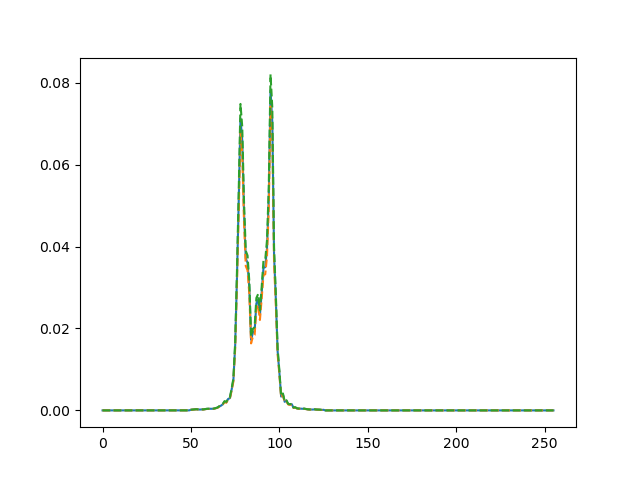

In [1677]:
profile_estim = np.squeeze(spat_pros)
profile_range = [0.95 * profile_estim, 1.05 * profile_estim]
flux_pix = np.tile(f_simu, (1, 256))
error_map = np.squeeze(np.sqrt(data+20**2))

plt.plot(profile_estim[1])
plt.plot(profile_range[0][1], "--")
plt.plot(profile_range[1][1], "--")

In [1706]:
# %%timeit
new_sp_pro, mask, good_pix, result = fit_profile_trust_constr(data.squeeze(), profile_estim, profile_range, flux_pix,
                         error_map, thresh_error=0.5, thresh_profile=1e-4, mask=None,
                         options={'verbose':True, 'maxiter':100, 'gtol':1e-5})

`gtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 25, CG iterations: 830, optimality: 9.59e-06, constraint violation: 4.44e-16, execution time: 0.83 s.


<IPython.core.display.Javascript object>


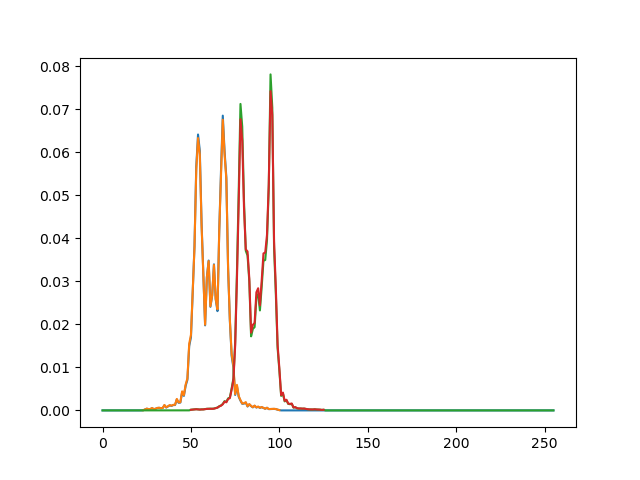

In [1707]:
plt.plot(profile_estim[0])
plt.plot(new_sp_pro[0])

plt.plot(profile_estim[1])
plt.plot(new_sp_pro[1])

# Test logl linear system

In [178]:
spat_pros_save = spat_pros

In [304]:
spat_pros = [sp_pro[:, :500] for sp_pro in spat_pros_save]
# spat_pros = [spat_pros_save[0]]

shape = spat_pros[0].shape

# f_simu = [np.arange(shape[1]) + 1000, np.arange(shape[1]) + 100]
f_simu = [np.ones(shape[1]) + 1000000, np.ones(shape[1]) + 10000]

data = []
mask_ord = []
b_vec = []
matrix = []
truth = []
for i in range(len(spat_pros)):
    f_simu_ord = np.tile(f_simu[i], (shape[0], 1))
    data.append(f_simu_ord * spat_pros[i])
#     error.append(np.ones(data[i].shape))
    mask_ord.append(spat_pros[i] < 1e-2)

mask = np.all(mask_ord, axis=0)
# mask = np.any(mask_ord, axis=0)
data = np.sum(data, axis=0)

data = np.random.poisson(data).astype(float)
data += np.random.normal(scale=20, size=data.shape)
error = np.sqrt(data)
for i in range(len(spat_pros)):
    f_simu_ord = np.tile(f_simu[i], (shape[0], 1))
    # build linear system
    b_vec.append(data[~mask] * f_simu_ord[~mask] / error[~mask]**2)
    truth.append(spat_pros[i][~mask])
    matrix.append(diags(f_simu_ord[~mask] / error[~mask]))
    
b_vec = np.concatenate(b_vec)
truth = np.concatenate(truth)

/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


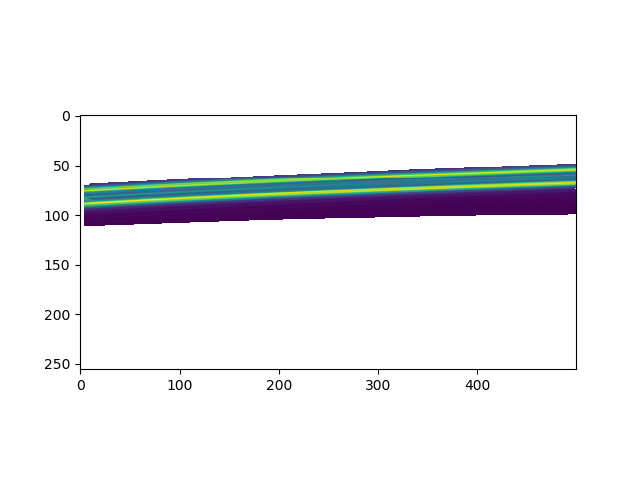

In [276]:
plt.imshow(np.ma.array(spat_pros[0], mask=mask))

In [305]:
matrix = hstack(matrix).T

In [306]:
matrix = matrix.dot(matrix.T)

In [308]:
estimate = 1.0 * truth

# system Ax = b to solve for relative error
a_matrix = matrix.dot(diags(estimate))
b_vec_err = b_vec - matrix.dot(estimate)


solution = spsolve(a_matrix, b_vec_err)
    

corrections = np.ones_like(spat_pros) * np.nan
corrections[0][~mask] = solution[:len(solution)//2]
corrections[1][~mask] = solution[len(solution)//2:]

    
new_spat_pros = np.asarray(spat_pros) * (1 + corrections)
rebuilt = new_spat_pros * np.asarray(f_simu)[:, None, :]
rebuilt = np.nansum(rebuilt, axis=0)

In [328]:
estimate = 1.0 * truth

# system Ax = b to solve for relative error
a_matrix = matrix.dot(diags(estimate))
b_vec_err = b_vec - matrix.dot(estimate)

# tikhonov
rel_error = error[~mask] / data[~mask]
gamma_matrix = diags(np.concatenate([rel_error, rel_error]))

logl_list = []
factor_list = np.logspace(-20, 6, 40)
for factor in factor_list:

    tikho_mat = a_matrix.T.dot(a_matrix) + factor * gamma_matrix.T.dot(gamma_matrix)
    tikho_b_vec = a_matrix.T.dot(b_vec_err)

    solution = spsolve(tikho_mat, tikho_b_vec)
    

    corrections = np.ones_like(spat_pros) * np.nan
    corrections[0][~mask] = solution[:len(solution)//2]
    corrections[1][~mask] = solution[len(solution)//2:]

    
    new_spat_pros = np.asarray(spat_pros) * (1 + corrections)
    rebuilt = new_spat_pros * np.asarray(f_simu)[:, None, :]
    rebuilt = np.nansum(rebuilt, axis=0)
    logl = np.nanmean((rebuilt - data)**2/error**2)
    logl_list.append(logl)

<IPython.core.display.Javascript object>


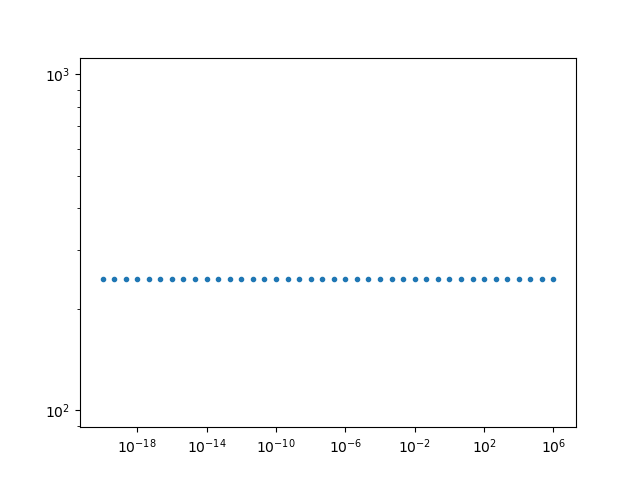

In [329]:
plt.loglog(factor_list, logl_list, '.')

In [330]:

factor = 1.e-2

tikho_mat = a_matrix.T.dot(a_matrix) + factor * gamma_matrix.T.dot(gamma_matrix)
tikho_b_vec = a_matrix.T.dot(b_vec_err)

solution = spsolve(tikho_mat, tikho_b_vec)



corrections = np.ones_like(spat_pros) * np.nan
corrections[0][~mask] = solution[:len(solution)//2]
corrections[1][~mask] = solution[len(solution)//2:]


new_spat_pros = np.asarray(spat_pros)*(1 + corrections)
rebuilt = np.nansum(new_spat_pros * np.asarray(f_simu)[:, None, :], axis=0)


<IPython.core.display.Javascript object>


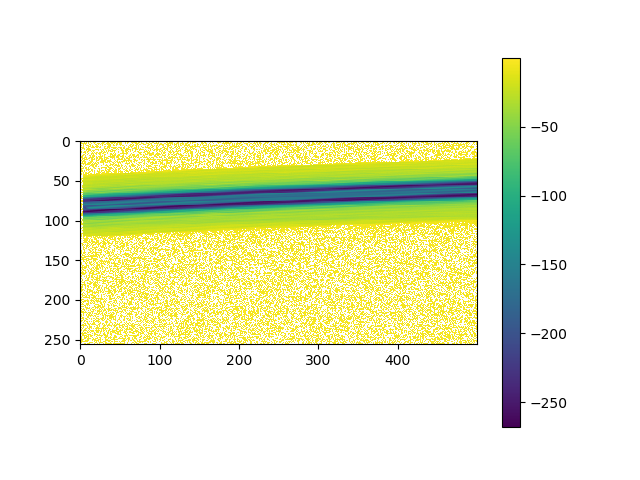

In [331]:
plt.imshow((rebuilt[0] - data)/error)
plt.colorbar()

<IPython.core.display.Javascript object>


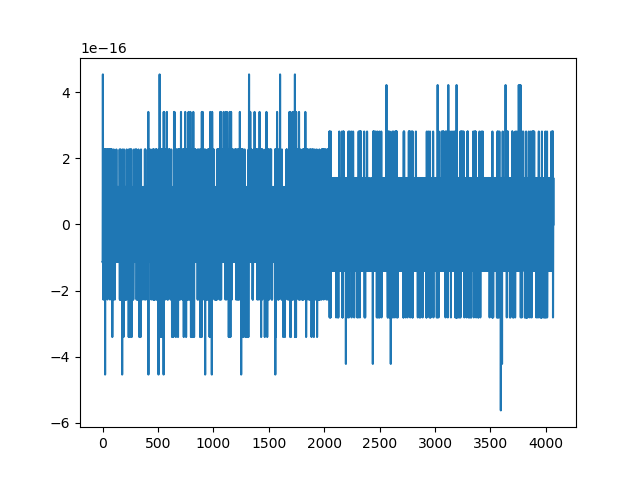

In [125]:
plt.plot((b_vec-matrix.dot(truth))/b_vec)
# plt.plot(matrix.dot(truth))

<IPython.core.display.Javascript object>


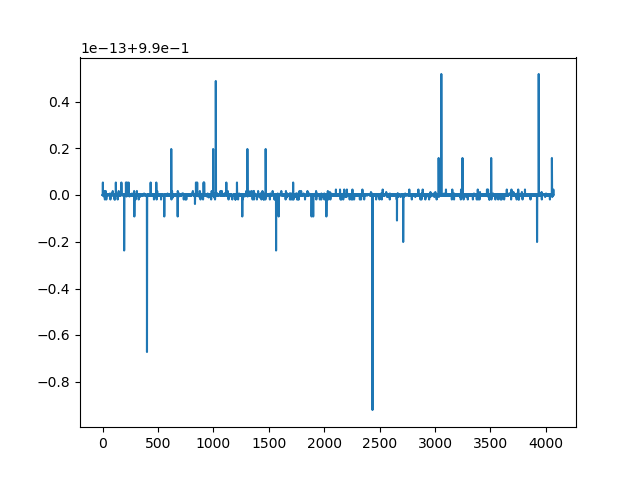

In [135]:
plt.plot((b_vec-matrix.dot(solution))/b_vec)

<IPython.core.display.Javascript object>


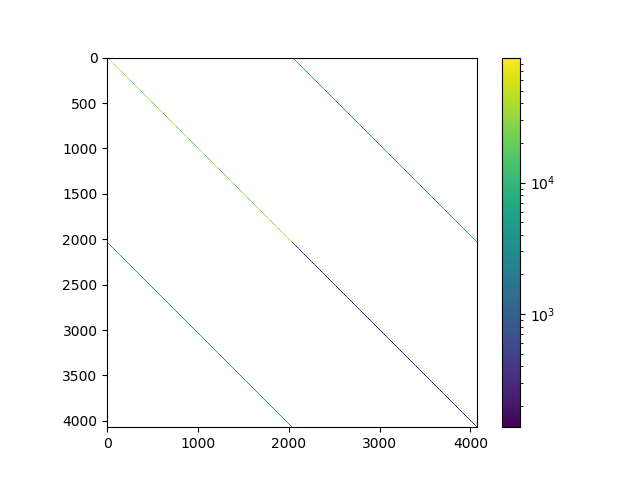

In [136]:
# plt.imshow(matrix.toarray()[:500, (matrix.shape[1] // 2):])
plt.imshow(matrix.toarray()[:, :], norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


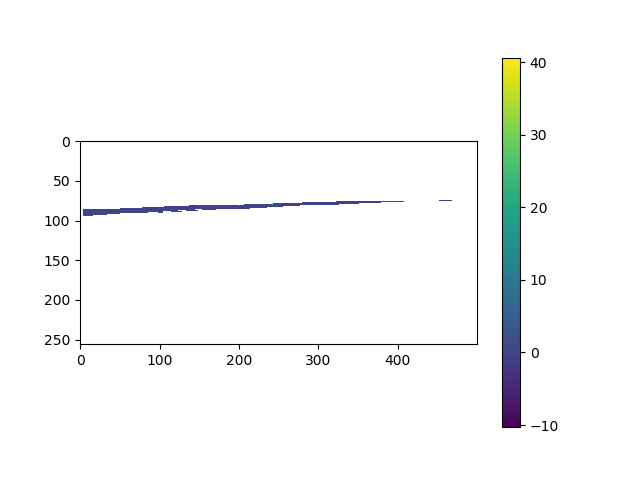

In [142]:
rebuilt = np.zeros(spat_pros[0].shape)
rebuilt[~mask] = solution[:len(b_vec)//2]
# plt.imshow(np.abs(rebuilt))
plt.imshow(0.9*spat_pros[0] + np.ma.array(rebuilt, mask=mask))

# plt.imshow(np.ma.array(spat_pros[0], mask=mask))

plt.colorbar()

In [138]:
data_vec = data1[~mask]
flux_vec = f_simu[~mask]


In [ ]:
spsolve()